In [4]:
#importing libraries 
import numpy as np
import pandas as pd

from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

from tqdm import tqdm_notebook as tqdm
from functools import partial
import scipy as sp

import random
import time
import sys
import os
import yaml

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models, datasets
from torchvision.models.feature_extraction import create_feature_extractor
from torch.utils.data import Dataset
from torch.autograd import Variable

import warnings
warnings.filterwarnings('ignore')

In [5]:
config_path = 'config/preprocessing_config.yaml'
conf = yaml.safe_load(open(config_path,'r'))
train_image_path = conf['train_dataset']['image_path']
test_image_path = conf['test_dataset']['image_path']
train_labels_path = conf['train_dataset']['label_path']
test_labels_path = conf['test_dataset']['label_path']
batch_size = conf['image_preprocessing']['batch_size']
shuffle = conf['image_preprocessing']['shuffle']
do_random_crop = conf['image_preprocessing']['do_random_crop']
columns = conf['image_preprocessing']['columns']
image_size = conf['image_preprocessing']['image_size']
itype = conf['image_preprocessing']['itype']
device = conf['metadata']['device']

In [6]:
from utils.dataloader import load_data
from train import *

In [7]:
#GPU CHECK
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available. Training on CPU...')
    device = torch.device('cpu')
else:
    print('CUDA is available. Training on GPU...')
    device = torch.device('cuda:0')

CUDA is available. Training on GPU...


In [8]:
# import data
train = pd.read_csv(train_labels_path)
test = pd.read_csv(test_labels_path)

# check shape
print(train.shape, test.shape)
print('-' * 15)
print(train[columns[1]].value_counts())
print('-' * 15)
print(test[columns[1]].value_counts())

(413, 12) (103, 3)
---------------
Retinopathy grade
2    136
0    134
3     74
4     49
1     20
Name: count, dtype: int64
---------------
Retinopathy grade
0    34
2    32
3    19
4    13
1     5
Name: count, dtype: int64


<class 'type'>
torch.Size([16, 3, 224, 224])


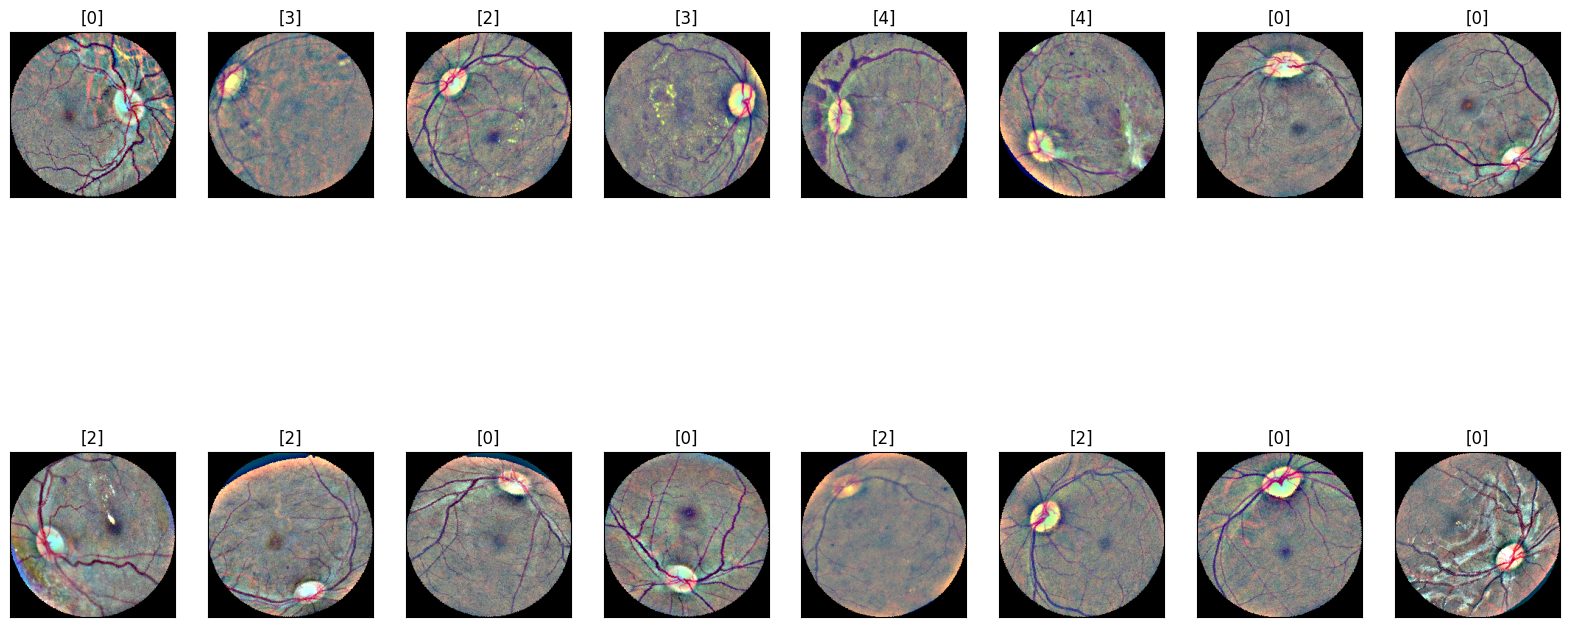

In [9]:
print(type(load_data))
loader = load_data(train_labels_path, test_labels_path, train_image_path, test_image_path, columns, itype = '.jpg', batch_size = 16, shuffle=True, do_random_crop = False, device = 'cpu')
train_loader, test_loader, valid_loader = loader.create_loader()
for batch_i, data in enumerate(train_loader):
    # extract data
    inputs = data['image']
    print(inputs.shape)
    labels = data['label'].view(-1, 1)
    # labels = data['label'].view(-1, 1)
    
    # create plot
    fig = plt.figure(figsize = (20,10))
    for i in range(len(labels)):
        ax = fig.add_subplot(2, int(len(labels)/2), i + 1, xticks = [], yticks = [])     
        plt.imshow(inputs[i].numpy().transpose(1, 2, 0))
        ax.set_title(labels.numpy()[i])
        
    break

In [13]:
import sklearn

def accuracy(y_true, y_pred):
    y_true = y_true.cpu()
    y_pred = y_pred.cpu()
    acc_vec = sklearn.metrics.accuracy_score(y_true, y_pred)
    return acc_vec.mean()

In [14]:
class ClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch['image'], batch['label']
        images, labels = images.to(device), labels.to(device)
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch['image'], batch['label'] 
        images, labels = images.to(device), labels.to(device)
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [15]:
class RetinopathyClassification(ClassificationBase):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
        
            nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            
            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(inplace=True),
            # nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            # nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        
        self.avgpool = nn.Sequential(
                      
            nn.AdaptiveAvgPool2d(output_size=(7, 7))
        )
    
        self.classifier = nn.Sequential(
            
            nn.Flatten(),  
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=1000, bias=True)
        )
        
        self.overall = nn.Sequential(
                      
            self.features,
            self.avgpool,
            self.classifier
        )
        
    def forward(self, xb):
        
        self.out = self.overall(xb)
        return self.out

In [16]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [17]:
# count = 0
# for batch in train_loader:
#     print(batch['image'].shape)
#     print(batch['label'].shape)
#     count = count+1
# print(count)
# count=0
# for batch in test_loader:
#     print(batch['image'].shape)
#     print(batch['label'].shape)
#     count=count+1
# print(count)
# count=0
# for batch in valid_loader:
#     print(batch['image'].shape)
#     print(batch['label'].shape)
#     count=count+1
# print(count)
# count=0

In [ ]:
model = RetinopathyClassification()
model = model.to(device)

num_epochs = 1
opt_func = torch.optim.Adam
lr = 0.001
# fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_loader, test_loader, opt_func)

# trainer = Trainner(model = model, epoch = 10)
# trainer.train()